In [1]:
import os, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb
import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS

In [2]:

args = argparse.Namespace()
args.gazeMpiimage_dir = '/project/data/Image'  # syn data 
args.gazeMpiilabel_dir = '/project/data/Label'  # syn label
args.output = '/project/results/soutput/snapshots/'  # real model
args.dataset = 'mpiigaze'
args.snapshot='/project/results/soutput/snapshots/'  # real data model
args.evalpath = '/project/results/rsoutput/evaluation/'
args.gpu_id = '0,1,2,3'
args.gpu_id = '0'
args.batch_size = 20
args.arch = 'ResNet50'
args.bins=28
args.angle = 180
args.bin_width = 4


In [3]:
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
evalpath =args.evalpath
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width

# args = parse_args()
cudnn.enabled = True
gpu = select_device(args.gpu_id, batch_size=args.batch_size)
transformations = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model_used=getArch(arch, bins)  #resnet50 and 28 bins

In [4]:
%%time

pitch_errs = {}
yaw_errs = {}

pitch_xs = []
pitch_ys = []
yaw_xs = []
yaw_ys =[]

for fold in range(15):
    print(f"fold={fold}")
    
    now = datetime.utcnow()
    now = now.astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S'
    now = now.strftime(date_format)
    
    print(args.gazeMpiilabel_dir)
    folder = os.listdir(args.gazeMpiilabel_dir)
    folder.sort()  #individual label files
    testlabelpathcombined = [os.path.join(args.gazeMpiilabel_dir, j) for j in folder] 
#     print(testlabelpathcombined)
#     print(args.gazeMpiimage_dir)
    gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, args.gazeMpiimage_dir, transformations, False, angle, fold)

    test_loader = torch.utils.data.DataLoader(
        dataset=gaze_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True)

    fold_path = os.path.join(evalpath, 'fold' + f'{fold:0>2}'+'/')  #for evaluation

    # list all epochs for testing
    folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
    folder.sort(key=natural_keys)
    folder.pop(-1)  #remove the tensorboard file, now all snapshot files
#     print(f"folder={folder}")  #contains all the checkpoint files
                    

    softmax = nn.Softmax(dim=1)
#     with open(os.path.join(evalpath, os.path.join("fold"+f'{fold:0>2}', data_set+".log")), 'w') as outfile:
        
    configuration = (f"\ntest configuration equal gpu_id={gpu}, batch_size={batch_size}, model_arch={arch}\n"
                     f"Start testing dataset={data_set}, FOLD={fold} --{now}---------")
    print(configuration)

#     outfile.write(configuration)
    epoch_list=[]
    avg_MAE=[]
    
    
    for epochs in folder: 
        x = ''.join(filter(lambda i: i.isdigit(), epochs))
        x = int(x)
        if x != 39:
            continue
#         print(f"epochs={epochs}")
        model=model_used
        checkpoint = torch.load(os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs))
#         print(f"checkpoint={checkpoint}")
        saved_state_dict = checkpoint['model_state_dict']
        model= nn.DataParallel(model,device_ids=[0])
        model.load_state_dict(saved_state_dict)
        model.cuda(gpu)
        model.eval()
        total = 0
        idx_tensor = [idx for idx in range(28)]
        idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
        avg_error = .0
        
        print(f"epochs={epochs}")
        
        with torch.no_grad():
            for j, (images, labels, cont_labels, name) in enumerate(test_loader):
#                 print(f"name={name}")
                images = Variable(images).cuda(gpu)
                total += cont_labels.size(0)

                label_pitch = cont_labels[:,0].float()*np.pi/180
                label_yaw = cont_labels[:,1].float()*np.pi/180

                gaze_pitch, gaze_yaw = model(images)

                # Binned predictions
                _, pitch_bpred = torch.max(gaze_pitch.data, 1)
                _, yaw_bpred = torch.max(gaze_yaw.data, 1)

                # Continuous predictions
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)

                # mapping from binned (0 to 28) to angels (-42 to 42)                
                pitch_predicted = \
                    torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 42
                yaw_predicted = \
                    torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 42

                pitch_predicted = pitch_predicted*np.pi/180
                yaw_predicted = yaw_predicted*np.pi/180

#                 print(f"name={name}")
#                 pitch_errors = []
#                 yaw_errors = []
#                 print("label_picthc", len(label_pitch), type(label_pitch), label_pitch)
#                 print("pitch_predicted", len(pitch_predicted), type(pitch_predicted), pitch_predicted)
#                 print("names", len(name), type(name), name)

                ## reverse labels
                label_pitch, label_yaw = label_pitch*(-1.0), label_yaw*(-1.0)
                
                pitch_errors = (pitch_predicted - label_pitch)*180/np.pi
                tdict = dict(zip(name, pitch_errors))
                pitch_errs.update(tdict)
                
                yaw_errors = (yaw_predicted - label_yaw)*180/np.pi
                tdict = dict(zip(name, yaw_errors))
                yaw_errs.update(tdict)
                
                label_pitch = label_pitch*180.0/np.pi
                label_yaw = label_yaw*180/np.pi
                pitch_xs.extend(label_pitch.numpy())
                pitch_ys.extend(pitch_errors.numpy())
                yaw_xs.extend(label_yaw.numpy())
                yaw_ys.extend(yaw_errors.numpy())
        
                


fold=0
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=0 --06/20/2022 17:56:56---------
epochs=epoch_39.pkl
fold=1
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=1 --06/20/2022 17:57:13---------
epochs=epoch_39.pkl
fold=2
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=2 --06/20/2022 17:57:25---------
epochs=epoch_39.pkl
fold=3
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=3 --06/20/2022 17:57:38---------
epochs=epoch_39.pkl
fold=4
/proj

In [5]:
pitch_errs = dict(sorted(pitch_errs.items(), key=lambda item: item[1], reverse=True))
yaw_errs = dict(sorted(yaw_errs.items(), key=lambda item: item[1], reverse=True))

In [6]:
pitch_errors = np.array(list(pitch_errs.values()))
yaw_errors = np.array(list(yaw_errs.values()))

In [7]:
# results shows only heatmap like figure and zoomed in?
# np.histogram(pitch_errors,bins=40)
# wandb.init(project="syn model real data signed errors reverse label")
# hist = np.histogram(pitch_errors, bins=40)
# wandb.log({'pitch_error_histogram': wandb.Histogram(np_histogram=hist,)})

In [8]:
# negative numbers got missing and unable to change bins
# wandb.init(project="syn model real data signed errors reverse label")
# data = [[e] for e in pitch_errors ]
# table = wandb.Table(data=data, columns=["pitch_errors"])
# wandb.log({'pitch_error_histogram': wandb.plot.histogram(table, "pitch_errors",
#            title='pitch signed errors')})

In [9]:
# wandb.init(project="syn model real data signed errors reverse label")
# data1 = [[e] for e in yaw_errors ]
# table = wandb.Table(data=data1, columns=["yaw_errors"])
# wandb.log({'yaw_error_histogram': wandb.plot.histogram(table, "yaw_errors",
#            title='yaw signed errors', bins=40)})


wandb: Currently logged in as: synthesis-ai (use `wandb login --relogin` to force relogin)


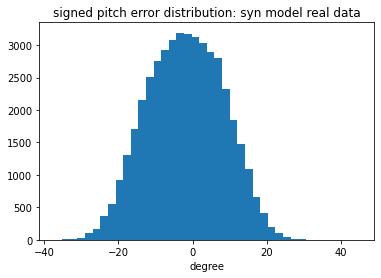

In [10]:
with wandb.init(project="reverse sign syn model real data signed errors") as run:
    plt.hist(pitch_errors, bins=40)
    plt.title("signed pitch error distribution: syn model real data")
    plt.xlabel("degree")
    run.log({"data":wandb.Image(plt)})
#     run.log({"changed_data":wandb.Image(plt)})

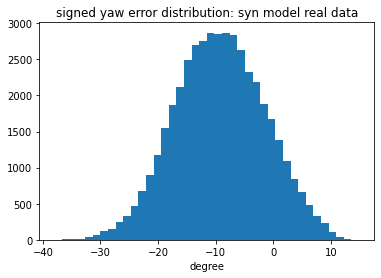

In [11]:
with wandb.init(project="reverse sign syn model real data signed errors") as run:
    plt.hist(yaw_errors, bins=40)
    plt.title("signed yaw error distribution: syn model real data")
    plt.xlabel("degree")
    run.log({"data":wandb.Image(plt)})

In [12]:
with wandb.init(project="reverse sign syn model real data signed errors") as run:
    data = [[x, y] for (x, y) in zip(pitch_xs, pitch_ys)]
    table = wandb.Table(data=data, columns = ["truth_degree", "error_degree"])
    wandb.log({"pitch_error_scatter" : wandb.plot.scatter(table, "truth_degree", "error_degree", title="pitch error vs ground truth")})
    

In [13]:
with wandb.init(project="reverse sign syn model real data signed errors") as run:
    data = [[x, y] for (x, y) in zip(yaw_xs, yaw_ys)]
    table = wandb.Table(data=data, columns = ["truth_degree", "error_degree"])
    wandb.log({"pitch_error_scatter" : wandb.plot.scatter(table, "truth_degree", "error_degree", title="yaw error vs ground truth")})
    

In [14]:
# plt.hist(pitch_errors, bins=40)
# plt.title("signed pitch error distribution: syn model real data")
# hists = plt.xlabel("degree")

In [15]:
# plt.hist(yaw_errors, bins=40)
# plt.title("signed yaw error distribution: syn model real data")
# plt.xlabel("degree")

In [16]:
# plt.scatter(pitch_xs, pitch_ys)
# plt.title("signed pitch error vs label")
# plt.xlabel("degree (labeled)")

In [17]:
# plt.scatter(yaw_xs, yaw_ys)
# plt.title("signed yaw error vs label")
# plt.xlabel("degree (labeled)")